In [6]:
import pandas as pd
import numpy as np
import re  
import statsmodels.api as sm
import statsmodels.formula.api as smf
#plot
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

In [7]:

# Read the CSV file
data_JE_raw = pd.read_csv("Data_JuliAndEmma.csv")
data_JE_raw


,library,B2_1,B1_1,B2_2,B1_2,aa,pos,mut
0,30166.0,57323,72527,30360,157106,NaN,-1,NaN
1,742.0,2747,838,4901,127,A,16,L
2,663.0,19,17,22,1974,E,5,D
3,567.0,1689,330,55,12653,F,2,L
4,529.0,592,323,824,1241,A,15,S
...,...,...,...,...,...,...,...,...
476,16.0,0,0,0,0,Q,25,D
477,14.0,0,13,0,0,G,9,H
478,13.0,0,0,0,0,V,22,C
479,13.0,0,0,139,0,V,8,Y


In [8]:
def formula(df, B1_col, B2_col):
    df = df[(df['library'] != 0) & ((df[B1_col] != 0) | (df[B2_col] != 0))] #remove rows that b1,b2 = 0 and library = 0
    df=df.applymap(lambda x: 0.1 if x == 0 else x) #value  0 -> 0.1
    
    df['B1dMut'] = (df[B1_col] / df[B1_col].iloc[0]) / (df['library'] / df['library'].iloc[0])
    df['B2dMut'] = (df[B2_col] / df[B2_col].iloc[0]) / (df['library'] / df['library'].iloc[0])
    df['changeB2_B1'] = df['B2dMut'] - df['B1dMut']
    
    return df[['pos', 'mut', 'changeB2_B1']]

In [9]:
JE_1 = formula(data_JE_raw[['pos', 'mut', 'B1_1', 'B2_1', 'library']].copy(), 'B1_1', 'B2_1')
JE_2 = formula(data_JE_raw[['pos', 'mut', 'B1_2', 'B2_2', 'library']].copy(), 'B1_2', 'B2_2')

data_JE = pd.concat([JE_1, JE_2]).sort_values(by='pos')
data_JE['pos'] = data_JE['pos'].astype(str)
data_JE['mut'].fillna('*', inplace=True)

data_JE

,pos,mut,changeB2_B1
0,-1,*,0.000000
0,-1,*,0.000000
38,2,M,-0.383757
45,2,V,6.111725
49,2,T,-0.045019
...,...,...,...
269,25,T,1.796750
260,25,L,-1.796783
184,25,S,1.354777
354,25,*,-0.029599


In [10]:
model = smf.glm('changeB2_B1 ~ C(pos, Treatment(reference="-1")) * mut', data=data_JE).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            changeB2_B1   No. Observations:                  601
Model:                            GLM   Df Residuals:                      214
Model Family:                Gaussian   Df Model:                          386
Link Function:               identity   Scale:                          60.796
Method:                          IRLS   Log-Likelihood:                -1774.7
Date:                Fri, 20 Oct 2023   Deviance:                       12920.
Time:                        10:01:25   Pearson chi2:                 1.29e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5750
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [11]:
# extract coef and p value from OLS output
coefficients = model.params[45:]
p_values = model.pvalues[45:]

# extract predictors from OLS output
predictors = model.params.index[45:]

# extract pos and mut values
pos_list =[]
mut_list =[]
for pre in predictors:
    pos_match = re.search(r'\[T.(\d+)\]', pre)
    pos_list.append(pos_match.group(1))
    
    mut_match = re.search(r'mut\[T.(.*)\]', pre) 
    mut_list.append(mut_match.group(1))

#DataFrame with the extracted data
ols_results = pd.DataFrame({'Coefficient': coefficients, 'P-Value': p_values, 'Position':pos_list, 'Mutation': mut_list})

# custom mutation order #can group amino acid to (+)(-)aromatic...
mut_order = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'][::-1]
ols_results['Mutation'] = pd.Categorical(ols_results['Mutation'], categories=mut_order, ordered=True)

#pos order
pos_order = [str(i) for i in range(2, 26)]
ols_results['Position'] = pd.Categorical(ols_results['Position'], categories=pos_order, ordered=True)

ols_results

,Coefficient,P-Value,Position,Mutation
"C(pos, Treatment(reference=""-1""))[T.10]:mut[T.A]",5.119587e-01,0.955705,10,A
"C(pos, Treatment(reference=""-1""))[T.11]:mut[T.A]",6.072591e-13,0.178735,11,A
"C(pos, Treatment(reference=""-1""))[T.12]:mut[T.A]",1.365352e+00,0.882628,12,A
"C(pos, Treatment(reference=""-1""))[T.13]:mut[T.A]",-1.155068e-13,0.271599,13,A
"C(pos, Treatment(reference=""-1""))[T.14]:mut[T.A]",6.601946e-01,0.902168,14,A
...,...,...,...,...
"C(pos, Treatment(reference=""-1""))[T.5]:mut[T.Y]",-1.315849e+00,0.886428,5,Y
"C(pos, Treatment(reference=""-1""))[T.6]:mut[T.Y]",2.765623e+00,0.716717,6,Y
"C(pos, Treatment(reference=""-1""))[T.7]:mut[T.Y]",-1.196947e-01,0.989618,7,Y
"C(pos, Treatment(reference=""-1""))[T.8]:mut[T.Y]",8.179218e+00,0.257485,8,Y


In [12]:
def get_alpha(p):
  if 0 < p < 0.001:
    return '***'
  elif 0.001< p < 0.01:
    return '**' 
  elif 0.01 < p < 0.05:
    return '*'
  elif 0.05 < p < 0.1:
    return '.'
  else:
    return ''
  
ols_results['alpha'] = ols_results['P-Value'].apply(get_alpha)
ols_results

,Coefficient,P-Value,Position,Mutation,alpha
"C(pos, Treatment(reference=""-1""))[T.10]:mut[T.A]",5.119587e-01,0.955705,10,A,
"C(pos, Treatment(reference=""-1""))[T.11]:mut[T.A]",6.072591e-13,0.178735,11,A,
"C(pos, Treatment(reference=""-1""))[T.12]:mut[T.A]",1.365352e+00,0.882628,12,A,
"C(pos, Treatment(reference=""-1""))[T.13]:mut[T.A]",-1.155068e-13,0.271599,13,A,
"C(pos, Treatment(reference=""-1""))[T.14]:mut[T.A]",6.601946e-01,0.902168,14,A,
...,...,...,...,...,...
"C(pos, Treatment(reference=""-1""))[T.5]:mut[T.Y]",-1.315849e+00,0.886428,5,Y,
"C(pos, Treatment(reference=""-1""))[T.6]:mut[T.Y]",2.765623e+00,0.716717,6,Y,
"C(pos, Treatment(reference=""-1""))[T.7]:mut[T.Y]",-1.196947e-01,0.989618,7,Y,
"C(pos, Treatment(reference=""-1""))[T.8]:mut[T.Y]",8.179218e+00,0.257485,8,Y,


In [13]:
#custom color map

top_color = (0 / 255, 139 / 255, 139 / 255)  #yellow
bottom_color = (255 / 255, 185 / 255, 15 / 255) #cyan

# set the position for the white color (where Coefficient = 0)
middle_position = abs(0 - min(ols_results['Coefficient'])) / (max(ols_results['Coefficient']) - min(ols_results['Coefficient']))
colors = [top_color, (1, 1, 1), bottom_color]
positions = [0.0, middle_position, 1.0]

custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))


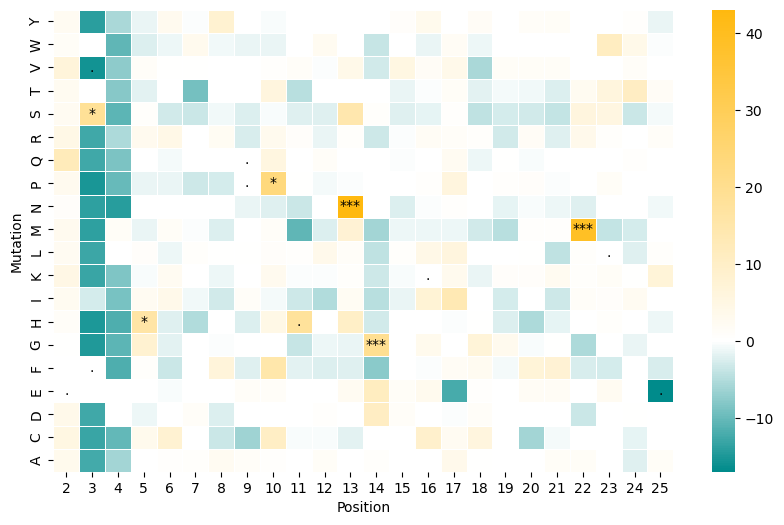

In [15]:
heatmap_data = ols_results.pivot_table(index='Mutation', columns='Position', values='Coefficient')

#the heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(heatmap_data, cmap=custom_cmap, linewidths=.5, cbar = True)
#add 'alpha' values to the heatmap
for i, row in enumerate(heatmap_data.index):
    for j, col in enumerate(heatmap_data.columns):
        alpha_value =ols_results[(ols_results['Mutation'] == row) & (ols_results['Position'] == col)]['alpha'].values[0]
        heatmap.text(j + 0.5, i + 0.5, alpha_value, ha='center', va='center', color='black')

plt.xlabel("Position")
plt.ylabel("Mutation")
plt.show()